In [8]:
import os
import shutil

# Paths
DATASET_DIR = '/kaggle/input/plantvillage/PlantVillage'
train_dir = os.path.join(DATASET_DIR, 'train')

val_dir = os.path.join(DATASET_DIR, 'val')
merged_dir = os.path.join('/kaggle/working', 'merged_data')  # Create in working directory

os.makedirs(merged_dir, exist_ok=True)

def merge_folders(src, dst):
    for class_name in os.listdir(src):
        src_class_path = os.path.join(src, class_name)
        dst_class_path = os.path.join(dst, class_name)

        os.makedirs(dst_class_path, exist_ok=True)

        for filename in os.listdir(src_class_path):
            src_file = os.path.join(src_class_path, filename)
            dst_file = os.path.join(dst_class_path, filename)
            shutil.copy2(src_file, dst_file)

# Merge both folders into merged_data
merge_folders(train_dir, merged_dir)
merge_folders(val_dir, merged_dir)

print("✅ Train and Val data successfully merged into:", merged_dir)


✅ Train and Val data successfully merged into: /kaggle/working/merged_data


In [ ]:
import tensorflow as tf
print(tf.__version__)

In [12]:
import os

# Set your training data path
train_dir = '/kaggle/working/merged_data'

# Loop through each folder and count the number of files
for folder in os.listdir(train_dir):
    folder_path = os.path.join(train_dir, folder)
    if os.path.isdir(folder_path):
        file_count = len([
            f for f in os.listdir(folder_path)
            if os.path.isfile(os.path.join(folder_path, f))
        ])
        print(f"{folder}: {file_count} files")


Corn_(maize)___Common_rust_: 1192 files
Tomato___Bacterial_spot: 2127 files
Tomato___Tomato_mosaic_virus: 373 files
Corn_(maize)___Northern_Leaf_Blight: 985 files
Pepper,_bell___healthy: 1478 files
Tomato___healthy: 1591 files
Tomato___Early_blight: 1000 files
Tomato___Target_Spot: 1404 files
Cherry_(including_sour)___healthy: 854 files
Grape___Black_rot: 1180 files
Soybean___healthy: 5090 files
Peach___Bacterial_spot: 2297 files
Tomato___Leaf_Mold: 952 files
Peach___healthy: 360 files
Grape___healthy: 423 files
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 513 files
Strawberry___healthy: 456 files
Apple___Black_rot: 621 files
Cherry_(including_sour)___Powdery_mildew: 1052 files
Potato___healthy: 658 files
Tomato___Septoria_leaf_spot: 1771 files
Grape___Esca_(Black_Measles): 1383 files
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1076 files
Potato___Early_blight: 1000 files
Squash___Powdery_mildew: 1835 files
Tomato___Spider_mites Two-spotted_spider_mite: 1676 files
Tomato___Tomat

In [11]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

folder_path = '/kaggle/working/merged_data/Potato___healthy'

# Step 1: Load the original images (keep them)
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.JPG', '.png'))]

images = []
for file in image_files:
    img = cv2.imread(os.path.join(folder_path, file))
    if img is not None:
        img = cv2.resize(img, (224, 224))
        images.append(img)

if not images:
    raise ValueError("❌ No images found in the folder!")

images = np.array(images)

# Step 2: Define augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest'
)

# Step 3: Augment and save
target_total = 500
generated = 0
batch_size = 10

for batch in datagen.flow(images, batch_size=batch_size, save_to_dir=folder_path,
                          save_prefix='aug', save_format='jpg'):
    generated += batch.shape[0]
    if generated >= target_total:
        break

print(f"✅ Augmentation complete! {generated} images saved to {folder_path}")


✅ Augmentation complete! 506 images saved to /kaggle/working/merged_data/Potato___healthy


In [13]:
import os

base_dir = '/kaggle/working/merged_data'
new_base = '/kaggle/working/final_split'  # where new folders will be created

splits = ['train', 'val', 'test']

for split in splits:
    for class_name in os.listdir(base_dir):
        split_dir = os.path.join(new_base, split, class_name)
        os.makedirs(split_dir, exist_ok=True)


In [14]:
import random
import shutil

split_ratios = {'train': 0.8, 'val': 0.1, 'test': 0.1}

for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)
    images = os.listdir(class_path)
    random.shuffle(images)

    total = len(images)
    train_end = int(split_ratios['train'] * total)
    val_end = train_end + int(split_ratios['val'] * total)

    split_data = {
        'train': images[:train_end],
        'val': images[train_end:val_end],
        'test': images[val_end:]
    }

    for split in splits:
        for img in split_data[split]:
            src = os.path.join(class_path, img)
            dst = os.path.join(new_base, split, class_name, img)
            shutil.copy2(src, dst)


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation and testing
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_gen = train_datagen.flow_from_directory(
    os.path.join(new_base, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    os.path.join(new_base, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    os.path.join(new_base, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 43834 images belonging to 38 classes.
Found 5467 images belonging to 38 classes.
Found 5510 images belonging to 38 classes.


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, Model
from tensorflow.keras.preprocessing import image

# Define input shape and number of classes
input_shape = (224, 224, 3)
n_classes = 38

# Use the Functional API to build the model
inputs = layers.Input(shape=input_shape)
x = layers.BatchNormalization()(inputs)
x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(512, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(n_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)
model.summary()

I0000 00:00:1750517726.996553      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 3)         │              12 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 107, 107, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 53, 53, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 51, 51, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 49, 49, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 20, 20, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       8,389,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 38)                  │           2,4

 Total params: 11,014,130 (42.02 MB)

 Trainable params: 11,014,124 (42.02 MB)

 Non-trainable params: 6 (24.00 B)

In [18]:
import keras
from keras import layers
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [19]:
history = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1750517761.706264     114 service.cc:148] XLA service 0x7df6b40167a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750517761.707177     114 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750517762.303778     114 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/1370 ━━━━━━━━━━━━━━━━━━━━ 1:24 62ms/step - accuracy: 0.0000e+00 - loss: 3.6354  

I0000 00:00:1750517770.392360     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1370/1370 ━━━━━━━━━━━━━━━━━━━━ 497s 351ms/step - accuracy: 0.2992 - loss: 2.6679 - val_accuracy: 0.6183 - val_loss: 1.3904
Epoch 2/20
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 471s 342ms/step - accuracy: 0.6724 - loss: 1.1236 - val_accuracy: 0.7082 - val_loss: 1.1110
Epoch 3/20
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 468s 340ms/step - accuracy: 0.7858 - loss: 0.6892 - val_accuracy: 0.7390 - val_loss: 0.9970
Epoch 4/20
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 494s 359ms/step - accuracy: 0.8417 - loss: 0.4925 - val_accuracy: 0.8003 - val_loss: 0.7503
Epoch 5/20
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 492s 357ms/step - accuracy: 0.8747 - loss: 0.3920 - val_accuracy: 0.8892 - val_loss: 0.3522
Epoch 6/20
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 491s 356ms/step - accuracy: 0.8961 - loss: 0.3280 - val_accuracy: 0.8833 - val_loss: 0.4241
Epoch 7/20
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 516s 375ms/step - accuracy: 0.9103 - loss: 0.2756 - val_accuracy: 0.9098 - val_loss: 0.3204
Epoch 8/20
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 480s 349ms/step - accuracy: 0.9

In [21]:
model.save('/kaggle/working/crop_disease_model_combined_data_augmentation.h5')

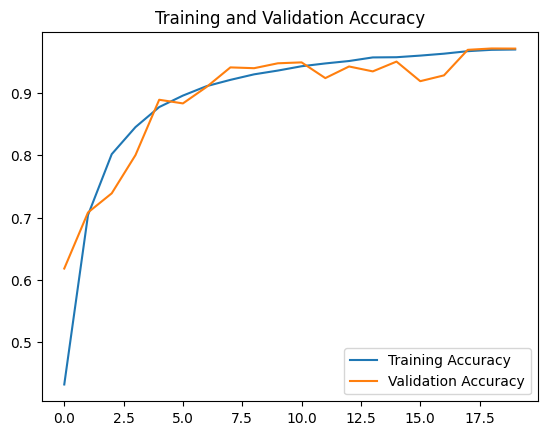

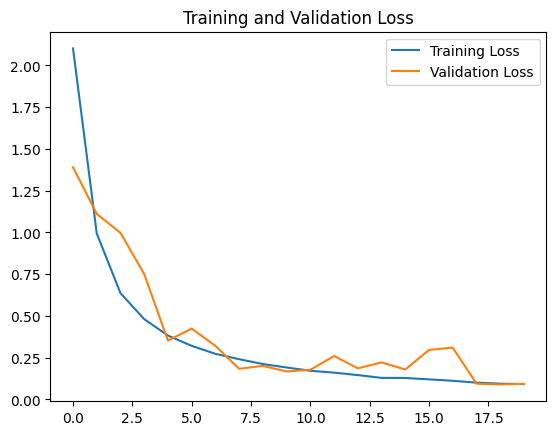

<Figure size 640x480 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
EPOCHS = 20
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
#plt.figure(figsize=(8,8))
#plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
#plt.subplot(1, 2, 2)
plt.show()
plt.savefig('AccVal_acc')
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig('LossVal_loss')

In [23]:
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9639 - loss: 0.1136
Test Accuracy: 96.95%


In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Step 1: Predict on test data
pred_probs = model.predict(test_gen)
y_pred = np.argmax(pred_probs, axis=1)

# Step 2: True labels
y_true = test_gen.classes

# Step 3: Get class labels
class_labels = list(test_gen.class_indices.keys())

# Step 4: Generate classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n")
print(report)

# Optional: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)


173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step
Classification Report:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      0.89      0.94        63
                                 Apple___Black_rot       1.00      0.98      0.99        63
                          Apple___Cedar_apple_rust       1.00      1.00      1.00        28
                                   Apple___healthy       0.89      0.96      0.92       165
                               Blueberry___healthy       1.00      0.92      0.96       151
          Cherry_(including_sour)___Powdery_mildew       0.99      0.97      0.98       106
                 Cherry_(including_sour)___healthy       0.99      0.97      0.98        86
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.73      0.92      0.81        52
                       Corn_(maize)___Common_rust_       0.98      0.99      0.99       120
             

173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step


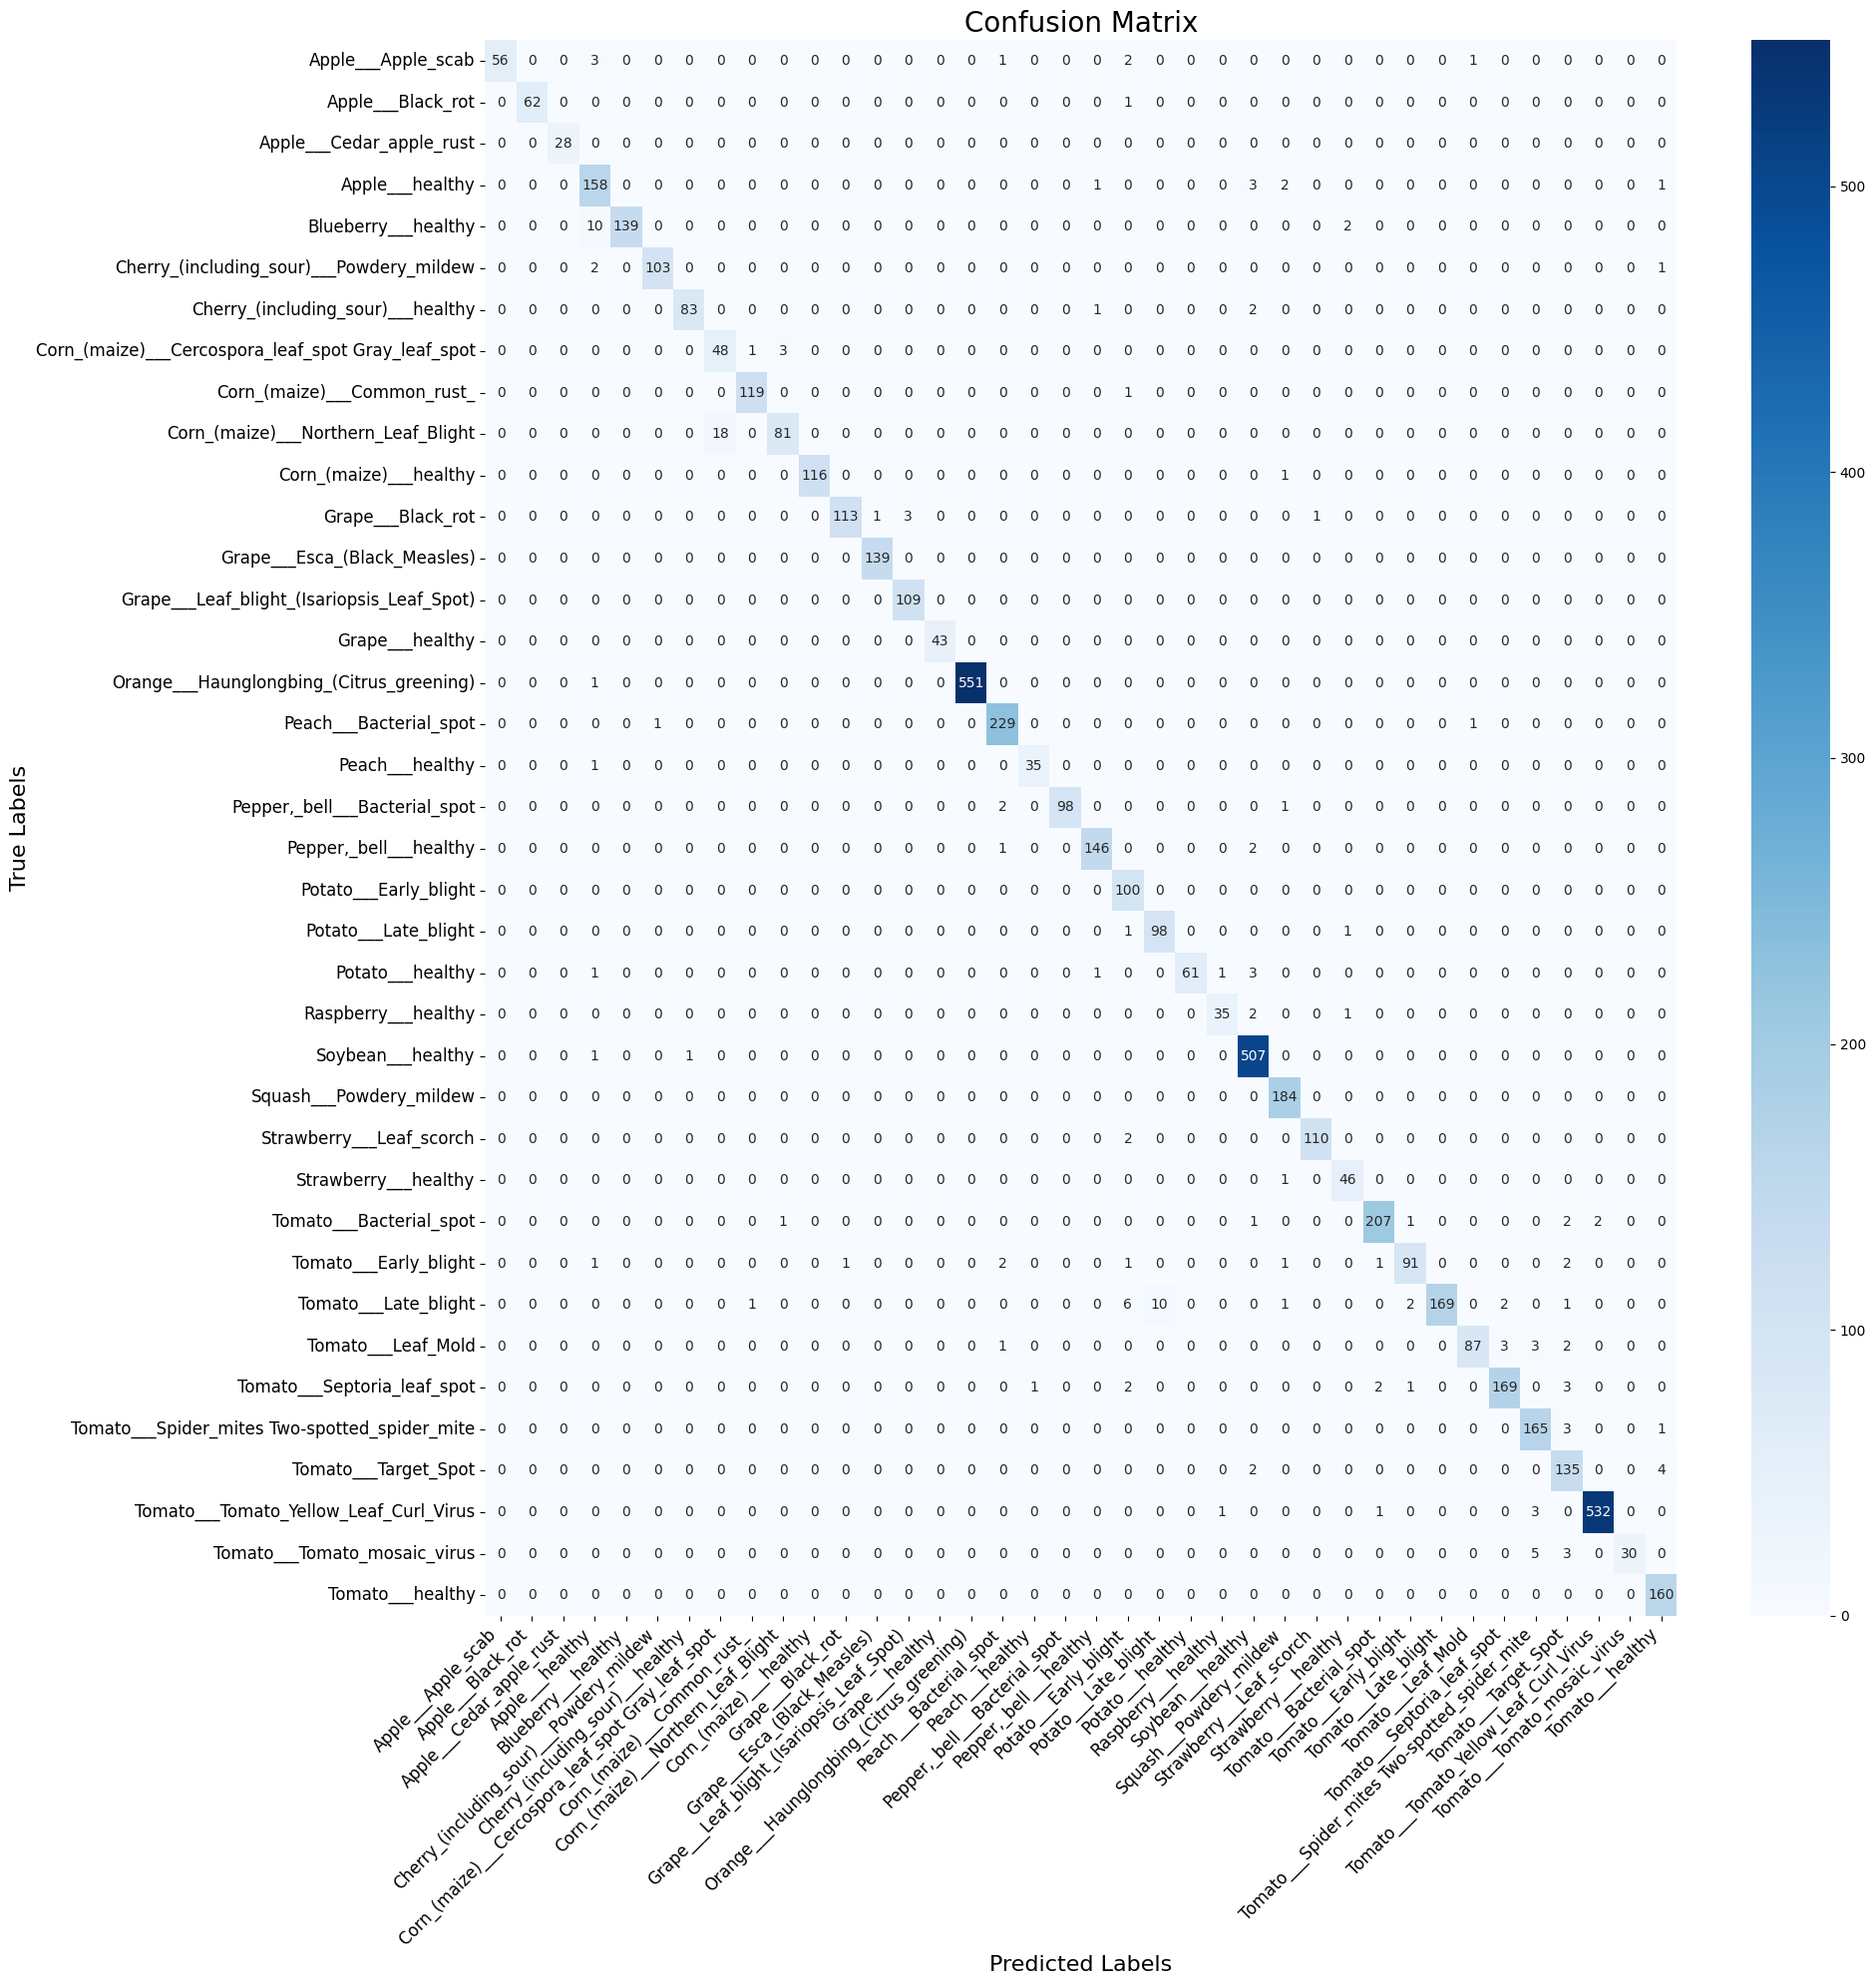

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Recompute if not done already
y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=1)
class_names = list(test_gen.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Set figure size dynamically
plt.figure(figsize=(20, 20))  # Adjust size based on number of classes

# Plot with heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar=True)

plt.xlabel('Predicted Labels', fontsize=16)
plt.ylabel('True Labels', fontsize=16)
plt.title('Confusion Matrix', fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()
